### The IDEAS project is supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Integrated Digital Earth Analysis System (IDEAS) API Demonstration

This notebook highlights some of the analytics and visualization capabilities of IDEAS with four use cases:
- Pakistan flooding occurring from June through September, 2022
- Hurricane Ian as it makes landfall over Florida in September, 2022
- France storm in January 2022
- LIS model data over the Mississippi river basin in January, 2020

## Libraries

The following libraries are needed to support accessing IDEAS API. The functions called in this notebook are in the `ideas_modules` folder

### Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import requests
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import box
from tabulate import tabulate
from IPython.display import Image
from owslib.util import Authentication
from owslib.wms import WebMapService
from PIL import Image as I
from PIL import ImageDraw

import ideas_modules.plotting as plotting
import ideas_modules.ideas_processing as ideas_processing

## Data Inventory
The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry point to access IDEAS API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov/nexus'

In [3]:
ideas_datasets = [
    'LIS-ESoil-tavg',
    'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed',
    'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed_clim',
]

url = f'{BASE_URL}/list'
print('url\n', url); print()
r = requests.get(url, verify=False).json()
inventories = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']]
inventories.sort_values('title')
print(tabulate( inventories[ inventories['title'].isin(ideas_datasets) ], headers="keys", showindex=False ))

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/list

title                                                           iso_start                 iso_end
--------------------------------------------------------------  ------------------------  ------------------------
GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed       2018-10-01T00:00:00+0000  2022-10-02T00:00:00+0000
GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed_clim  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000
LIS-ESoil-tavg                                                  2019-12-01T00:00:00+0000  2020-01-31T00:00:00+0000


## IDEAS API

### API List
The capabilities endpoint is used get a list of API offered by IDEAS.

In [4]:
url = f'{BASE_URL}/capabilities'
print('url\n', url); print()

r = requests.get(url, verify=False).json()
apis = pd.DataFrame(r)[['name', 'path', 'description']]
apis.sort_values('name')

print(tabulate(apis, headers="keys", showindex=False))

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/capabilities

name                                        path                           description
------------------------------------------  -----------------------------  --------------------------------------------------------------------------------------------------------------------
Capabilities                                /capabilities                  Lists the current capabilities of this Nexus system
Correlation Map                             /correlationMap                Computes a correlation map between two datasets given an arbitrary geographical area and time range
Daily Difference Average                    /dailydifferenceaverage        Subtracts data in box in Dataset 1 from Dataset 2, then averages the difference per day.
Data In-Bounds Search                       /datainbounds                  Fetches point values for a given dataset and geographical area
Dataset List                                /list    

# Pakistan Flood 2022

Find the peak of the flood using GPM precipitation data and visualize it.

- data set: GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed
- spatial bounds:  63, 23, 75, 33
- temporal bounds: 2022-06-01 to 2022-09-25
- area of interest: Pakistan

In [5]:
bb_pakistan_flood       = {'min_lon': 66, 'max_lon': 75, 'min_lat': 23, 'max_lat': 35}
start_pakistan_flood    = datetime(2022, 6, 1)
end_pakistan_flood      = datetime(2022, 9, 25)
global_precipitation_dataset  = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed'
pakistan_parameters = (BASE_URL, global_precipitation_dataset, bb_pakistan_flood, start_pakistan_flood, end_pakistan_flood)

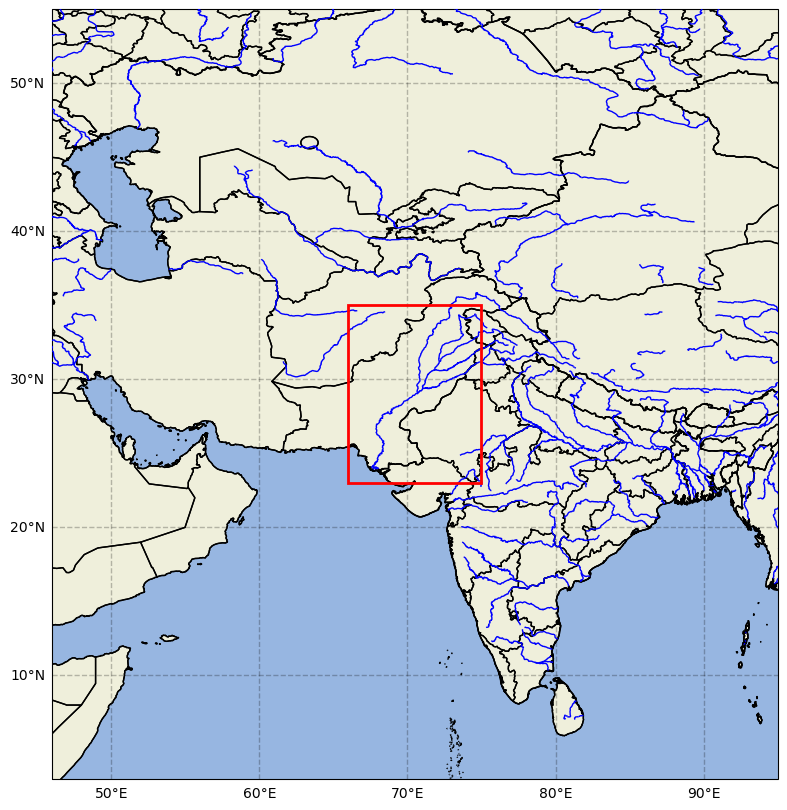

In [6]:
plotting.map_box(bb_pakistan_flood)

#### GPM Mean From 2022-08-01 to 2022-09-25

In [7]:
pakistan_timeseries = ideas_processing.spatial_timeseries(*pakistan_parameters)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&minLon=66&minLat=23&maxLon=75&maxLat=35&startTime=2022-06-01T00:00:00Z&endTime=2022-09-25T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 4.8170932499924675 seconds


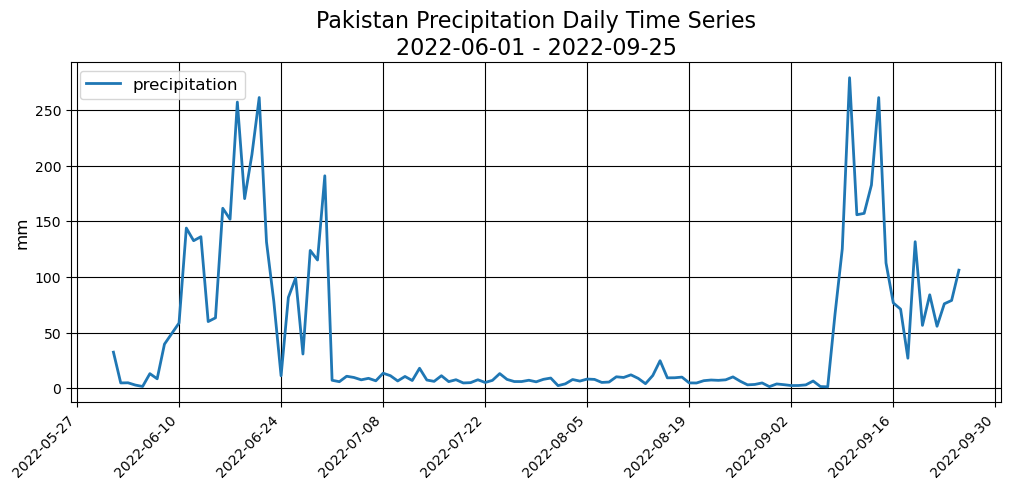

In [8]:
title = f'Pakistan Precipitation Daily Time Series\n{str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.timeseries_plot([(pakistan_timeseries['maximum'], 'precipitation')], '', 'mm', title)

**For more context, in the 2021 water year (October 1st 2020 to Sept 30th 2021), the state of California received about 300 mm of precipitation. This is only slightly more than the precipitation Pakistan was receiving some days during the floods.**

#### Data Subsetting

Fetches point values for a given dataset and geographical area.

In [9]:
pakistan_date = datetime(2022, 9, 12)
pakistan_subset_data = ideas_processing.data_subsetting(BASE_URL, global_precipitation_dataset, bb_pakistan_flood, pakistan_date, pakistan_date)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&b=66,23,75,35&startTime=2022-09-12T00:00:00Z&endTime=2022-09-12T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.8431401670095511 seconds


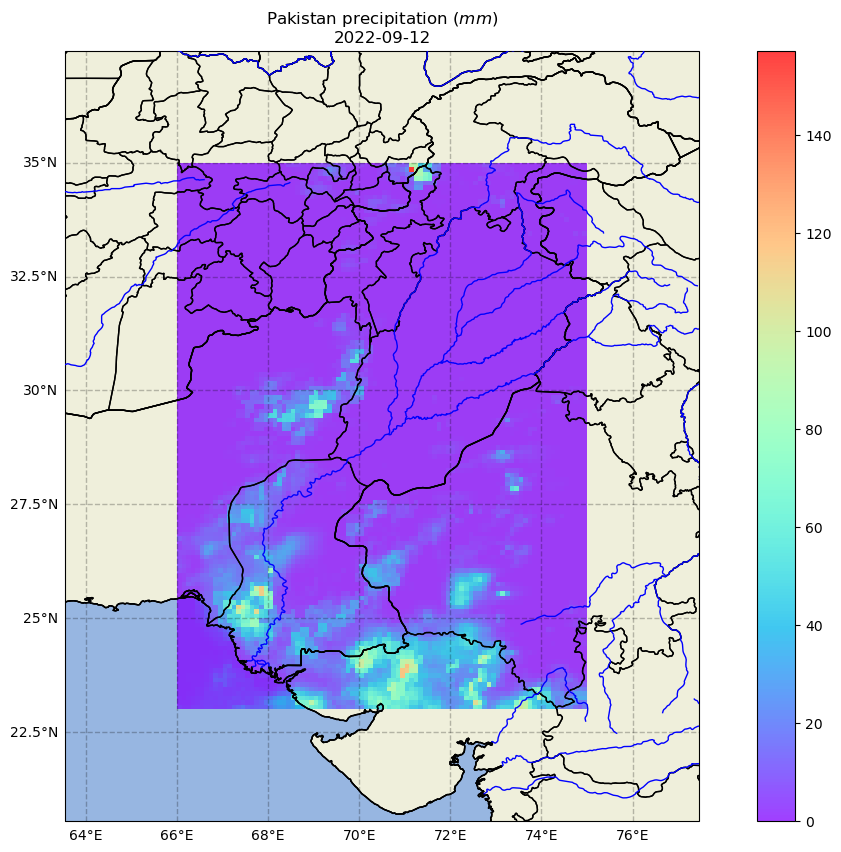

In [10]:
plotting.map_data(pakistan_subset_data[0], f'Pakistan precipitation ($mm$)\n{str(pakistan_date)[:10]}')

#### IDEAS WMS Visual GPM Precipitation 2022-09-12

In [11]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'IMERG_Precipitation_Rate',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(66,23,75,35),  # Bounds
                 size=(500, 500),  # Image size
                 time='2022-09-12',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

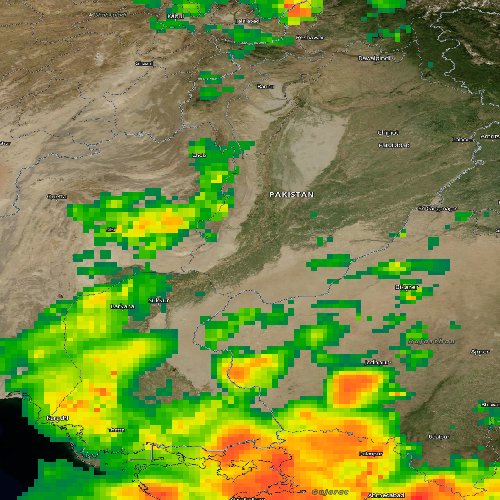

In [12]:
# View image
Image(img.read())

#### IDEAS WMS Animation 2022-08-01 to 2022-09-30

In [13]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 8, 1)
edate = datetime(2022, 9, 30)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(66,23,75,35),  # Bounds
                     size=(500,500),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('IMERG_Precipitation_Rate.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)


KeyboardInterrupt



In [ ]:
Image('IMERG_Precipitation_Rate.gif')

#### Temporal Mean

Computes a Latitude/Longitude Time Average plot given an arbitrary geographical area and time range

In [ ]:
pakistan_timeavg_data = ideas_processing.temporal_mean(*pakistan_parameters)

In [ ]:
pakistan_timeavg_title = f'Pakistan average precipitation ($mm$)\n{str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.map_data(pakistan_timeavg_data, pakistan_timeavg_title)

#### Maxima and Minima Map

Computes a map of maxmima and minima of a field given an arbitrary geographical area and time range.

In [ ]:
pakistan_max_min_data = ideas_processing.max_min_map_spark(*pakistan_parameters)

In [ ]:
pakistan_max_title = f'Pakistan maximum precipitation ($mm$)\n{str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.map_data(pakistan_max_min_data.maxima, pakistan_max_title)

#### Temporal Variance

Computes a map of the temporal variance of a field given an arbitrary geographical area and time range.

In [ ]:
pakistan_variance_data = ideas_processing.temporal_variance(*pakistan_parameters)

In [ ]:
pakistan_variance_title = f'Pakistan precipitation variance ($mm^2/s^2$)\n\
    {str(start_pakistan_flood)[:10]} - {str(end_pakistan_flood)[:10]}'
plotting.map_data(pakistan_variance_data, pakistan_variance_title)

#### Daily Difference Average

Subtracts data in box in Dataset 1 from Dataset 2 (i.e. climatology), then averages the difference per day.

In [ ]:
global_precipitation_computed_climatology = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed_clim'
pakistan_daily_diff_data = ideas_processing.daily_diff(BASE_URL, global_precipitation_dataset, global_precipitation_computed_climatology, bb_pakistan_flood, start_pakistan_flood, end_pakistan_flood)

In [ ]:
plotting.timeseries_plot([(pakistan_daily_diff_data['mean'], 'mean'), (pakistan_daily_diff_data['std'], 'std')], '', 'mm', title='Pakistan Precipitation Anomalies')

## Hurricane Ian Florida Landfall

In [ ]:
bb_hurricane_ian      = {'min_lon': -87, 'max_lon': -72, 'min_lat': 18, 'max_lat': 35}
start_hurricane_ian   = datetime(2022, 9, 24)
end_hurricane_ian     = datetime(2022, 10, 2)
ian_parameters = (BASE_URL, global_precipitation_dataset, bb_hurricane_ian, start_hurricane_ian, end_hurricane_ian)

In [ ]:
# Plot a box around our spatial bounds
plotting.map_box(bb_hurricane_ian)

In [ ]:
ian_timeseries = ideas_processing.spatial_timeseries(*ian_parameters)

In [ ]:
ian_title = f'Hurricane Ian Precipitation Time Series\n{str(start_hurricane_ian)[:10]} - {str(end_hurricane_ian)[:10]}'
plotting.timeseries_plot([(ian_timeseries.maximum, 'precipitation')], '', 'mm', ian_title)

In [ ]:
ian_start = datetime(2022,9,25)
ian_end = datetime(2022,10,1)
ian_precipitation_data = ideas_processing.temporal_mean(BASE_URL, global_precipitation_dataset, bb_hurricane_ian, ian_start, ian_end)

In [ ]:
ian_title = f'Precipitation average ($mm$)\n{str(ian_start)[:10]} - {str(ian_end)[:10]}'
plotting.map_data(ian_precipitation_data, ian_title)

#### Daily Difference Average

Subtracts data in box in Dataset 1 from Dataset 2 (i.e. climatology), then averages the difference per day.

In [ ]:
ian_daily_diff_data = ideas_processing.daily_diff(BASE_URL, global_precipitation_dataset, global_precipitation_computed_climatology, bb_hurricane_ian, start_hurricane_ian, end_hurricane_ian)

In [ ]:
plotting.timeseries_plot([(ian_daily_diff_data['mean'], 'mean'), (ian_daily_diff_data['std'], 'std')], '', 'mm', title='Hurricane Ian Precipitation Anomalies')

In [ ]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'IMERG_Precipitation_Rate',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-87, 18, -72, 35),  # Bounds
                 size=(600, 600),  # Image size
                 time='2022-09-28',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('IMERG_Precipitation_Rate_2022-09-28.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('IMERG_Precipitation_Rate_2022-09-28.png')

In [ ]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 9, 25)
edate = datetime(2022, 10, 1)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(-87, 18, -72, 35),  # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('IMERG_Precipitation_Rate_Ian.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('IMERG_Precipitation_Rate_Ian.gif')

## France storm 2021-12-31 - 2022-01-31

In [ ]:
bb_france      = {'min_lon': -4.297, 'max_lon': 4.324, 'min_lat': 41.662, 'max_lat': 48.845}
start_france   = datetime(2021, 12, 31)
end_france     = datetime(2022, 1, 31)
france_parameters = (BASE_URL, global_precipitation_dataset, bb_france, start_france, end_france)

In [ ]:
# Plot a box around our spatial bounds
plotting.map_box(bb_france)

In [ ]:
france_timeseries = ideas_processing.spatial_timeseries(*france_parameters)

In [ ]:
france_title = f'France Precipitation Time Series\n{str(start_france)[:10]} - {str(end_france)[:10]}'
plotting.timeseries_plot([(france_timeseries.maximum, 'precipitation')], '', 'mm', france_title)

In [ ]:
france_start = datetime(2022,1,5)
france_end = datetime(2022,1,10)
france_precipitation_data = ideas_processing.temporal_mean(BASE_URL, global_precipitation_dataset, bb_france, france_start, france_end)

In [ ]:
france_title = f'Precipitation average ($mm$)\n{str(france_start)[:10]} - {str(france_end)[:10]}'
plotting.map_data(france_precipitation_data, france_title)

#### Daily Difference Average

Subtracts data in box in Dataset 1 from Dataset 2 (i.e. climatology), then averages the difference per day.

In [ ]:
france_daily_diff_data = ideas_processing.daily_diff(BASE_URL, global_precipitation_dataset, global_precipitation_computed_climatology, bb_france, start_france, end_france)

In [ ]:
plotting.timeseries_plot([(france_daily_diff_data['mean'], 'mean'), (france_daily_diff_data['std'], 'std')], '', 'mm', title='Precipitation Anomalies over France')

In [ ]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'IMERG_Precipitation_Rate',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=( -4.297, 41.662, 4.324, 48.845),  # Bounds
                 size=(600, 600),  # Image size
                 time='2022-01-09',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('IMERG_Precipitation_Rate_2022-01-09.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('IMERG_Precipitation_Rate_2022-01-09.png')

In [ ]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['MODIS_Aqua_CorrectedReflectance_TrueColor',
          'IMERG_Precipitation_Rate',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 1, 1)
edate = datetime(2022, 1, 13)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=( -4.297, 41.662, 4.324, 48.845),  # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'IMERG Precipitation Rate   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('IMERG_Precipitation_Rate_Garonne.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('IMERG_Precipitation_Rate_Garonne.gif')

# Flooding in Mississippi River Basin

In [10]:
miss_bb       = {'min_lon': -92, 'max_lon': -90, 'min_lat': 32.3, 'max_lat': 34}
miss_start    = datetime(2019, 2, 14)
miss_end     = datetime(2019, 8, 31)
miss_lis_params = [(BASE_URL, ds, miss_bb, miss_start, miss_end) for ds in ['LIS_miss_1x_Qs_tavg', 'LIS_miss_1x_Qsb_tavg']]

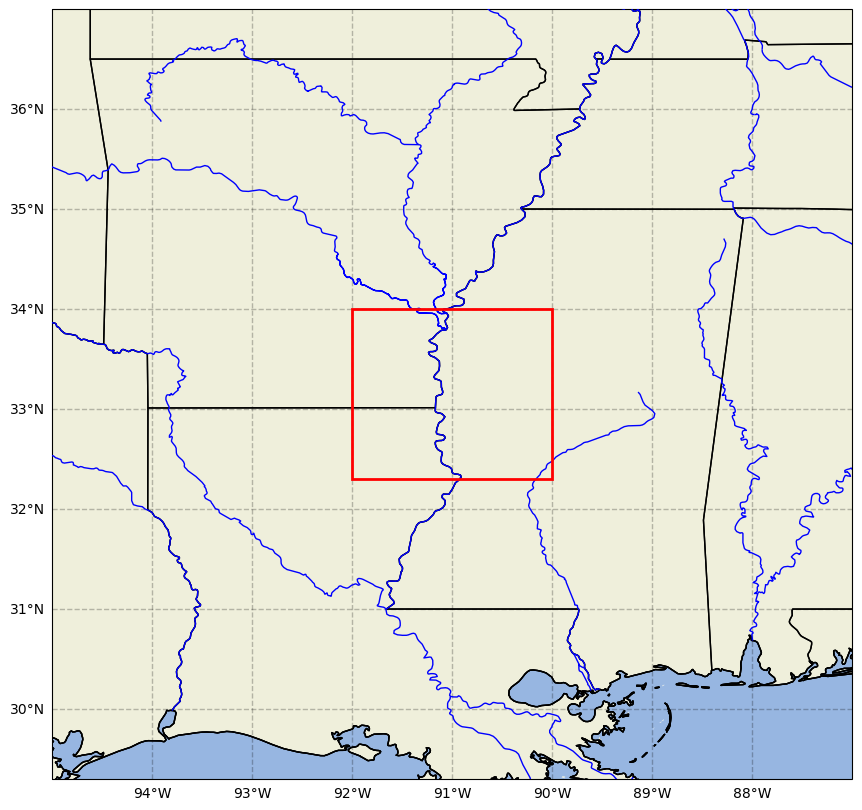

In [8]:
plotting.map_box(miss_bb, 3)

In [9]:
gpm_miss_ts = ideas_processing.spatial_timeseries(BASE_URL, 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed', miss_bb, miss_start, miss_end)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&minLon=-92&minLat=32.3&maxLon=-90&maxLat=34&startTime=2019-02-14T00:00:00Z&endTime=2019-08-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 4.4961607090663165 seconds


## LIS Runoff and GPM Precipitation

In [11]:
lis_miss_ts = [ideas_processing.spatial_timeseries(*miss_param) for miss_param in miss_lis_params]

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=LIS_miss_1x_Qs_tavg&minLon=-92&minLat=32.3&maxLon=-90&maxLat=34&startTime=2019-02-14T00:00:00Z&endTime=2019-08-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.46168887498788536 seconds
url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=LIS_miss_1x_Qsb_tavg&minLon=-92&minLat=32.3&maxLon=-90&maxLat=34&startTime=2019-02-14T00:00:00Z&endTime=2019-08-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.5157845001667738 seconds


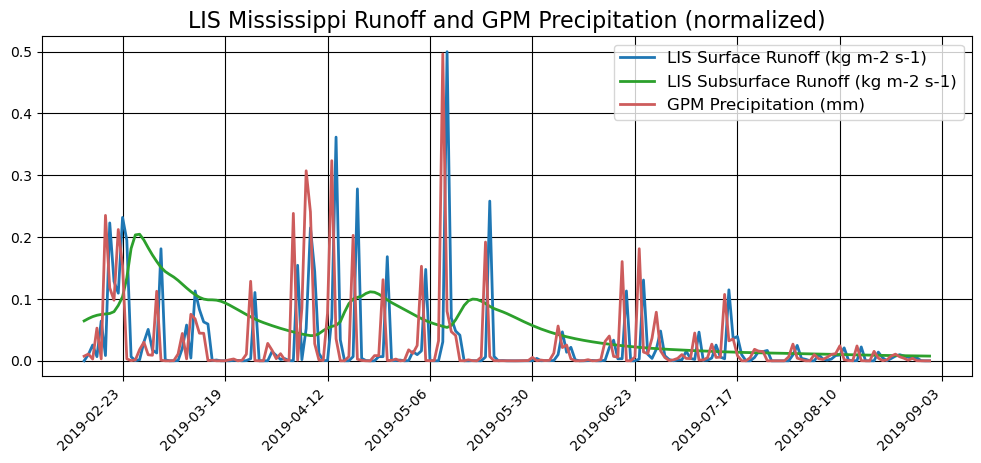

In [13]:
plotting.timeseries_plot([(lis_miss_ts[0]['mean'], 'LIS Surface Runoff (kg m-2 s-1)', 'tab:blue'), (lis_miss_ts[1]['mean'], 'LIS Subsurface Runoff (kg m-2 s-1)', 'tab:green'), (gpm_miss_ts['mean'], 'GPM Precipitation (mm)', 'indianred')], '', '', 'LIS Mississippi Runoff and GPM Precipitation (normalized)', norm=True)

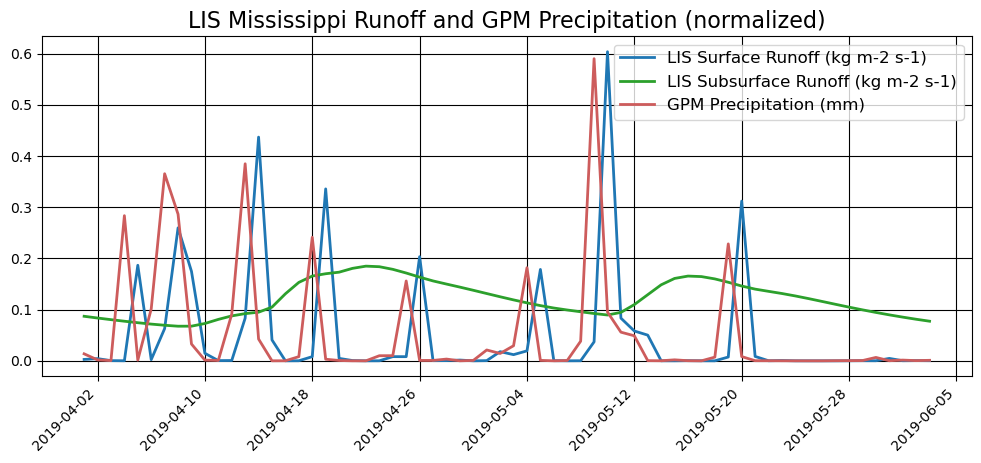

In [14]:
plotting.timeseries_plot([(lis_miss_ts[0]['mean'][46:110], 'LIS Surface Runoff (kg m-2 s-1)', 'tab:blue'), (lis_miss_ts[1]['mean'][46:110], 'LIS Subsurface Runoff (kg m-2 s-1)', 'tab:green'), (gpm_miss_ts['mean'][46:110], 'GPM Precipitation (mm)', 'indianred')], '', '', 'LIS Mississippi Runoff and GPM Precipitation (normalized)', norm=True)

## VIC Runoff and GPM Precipitation

In [15]:
miss_vic_params = [(BASE_URL, ds, miss_bb, miss_start, miss_end) for ds in ['GLDAS_VIC10_3H_2_1_global_Qs_acc', 'GLDAS_VIC10_3H_2_1_global_Qsb_acc']]

In [16]:
vic_miss_ts = [ideas_processing.spatial_timeseries(*miss_param) for miss_param in miss_vic_params]

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GLDAS_VIC10_3H_2_1_global_Qs_acc&minLon=-92&minLat=32.3&maxLon=-90&maxLat=34&startTime=2019-02-14T00:00:00Z&endTime=2019-08-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 3.805393708869815 seconds
url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GLDAS_VIC10_3H_2_1_global_Qsb_acc&minLon=-92&minLat=32.3&maxLon=-90&maxLat=34&startTime=2019-02-14T00:00:00Z&endTime=2019-08-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.1658181250095367 seconds


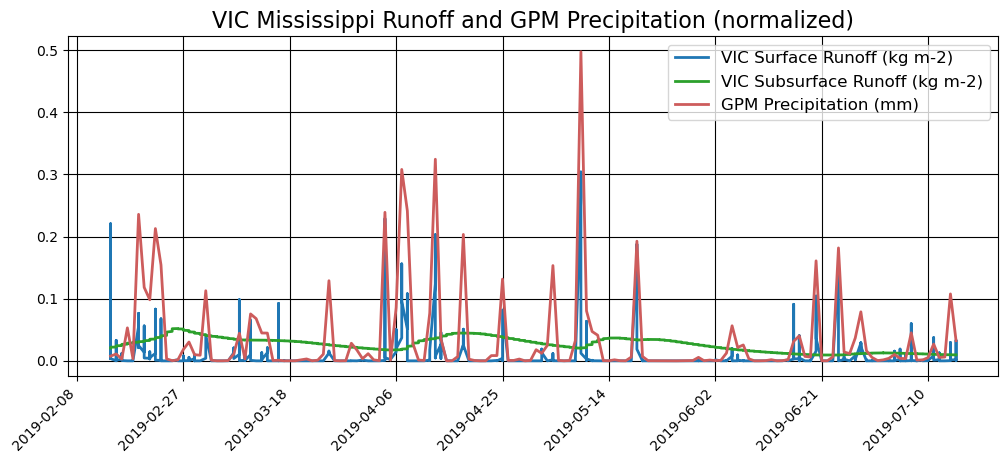

In [17]:
plotting.timeseries_plot([(vic_miss_ts[0]['mean'], 'VIC Surface Runoff (kg m-2)', 'tab:blue'), (vic_miss_ts[1]['mean'], 'VIC Subsurface Runoff (kg m-2)', 'tab:green'), (gpm_miss_ts['mean'][:152], 'GPM Precipitation (mm)', 'indianred')], '', '', 'VIC Mississippi Runoff and GPM Precipitation (normalized)', norm=True)

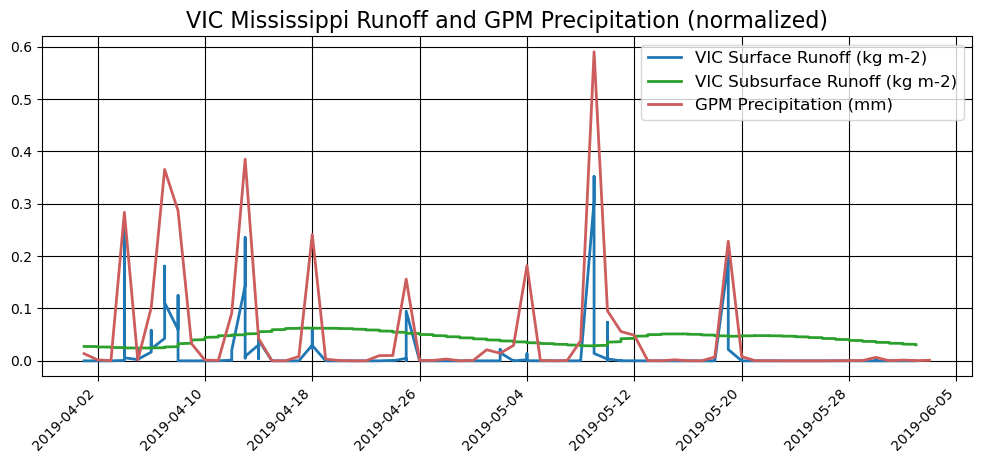

In [18]:
plotting.timeseries_plot([(vic_miss_ts[0]['mean'][375:870], 'VIC Surface Runoff (kg m-2)', 'tab:blue'), (vic_miss_ts[1]['mean'][375:870], 'VIC Subsurface Runoff (kg m-2)', 'tab:green'), (gpm_miss_ts['mean'][46:110], 'GPM Precipitation (mm)', 'indianred')], '', '', 'VIC Mississippi Runoff and GPM Precipitation (normalized)', norm=True)

## Mississippi RAPID

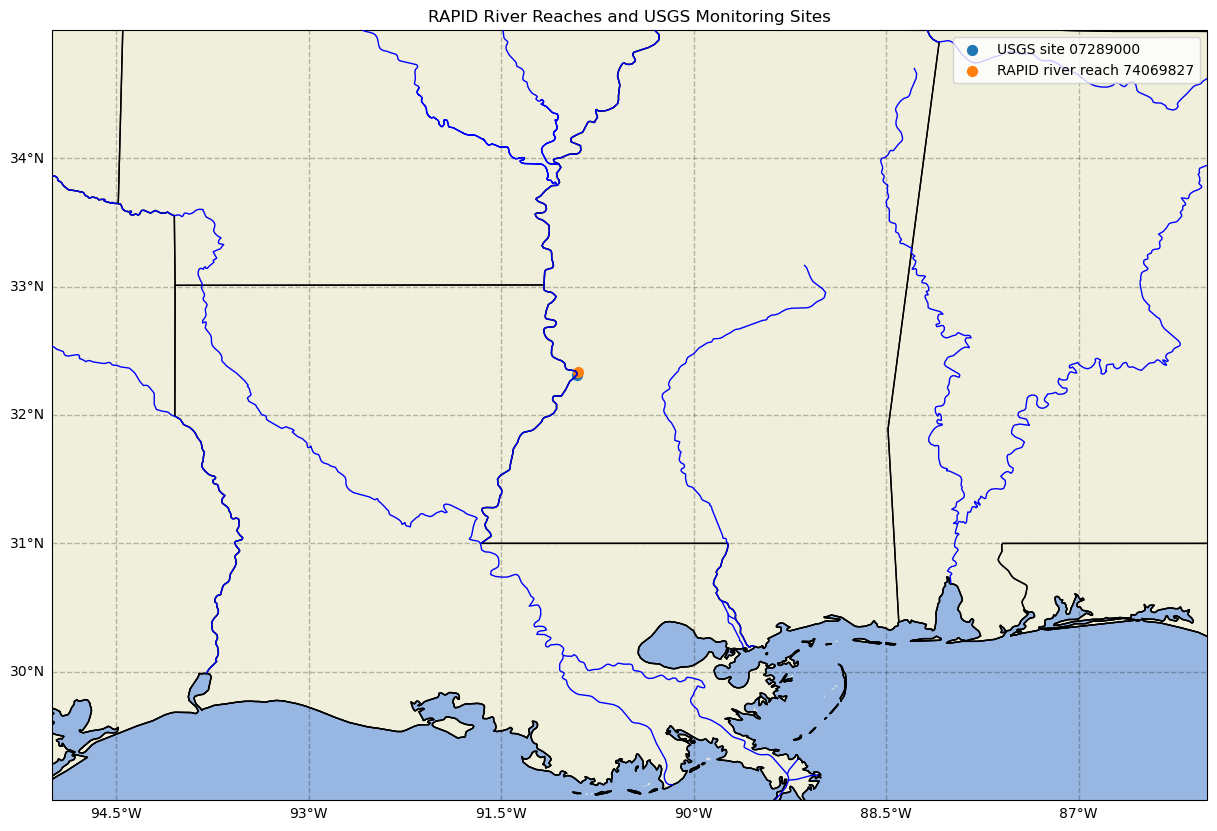

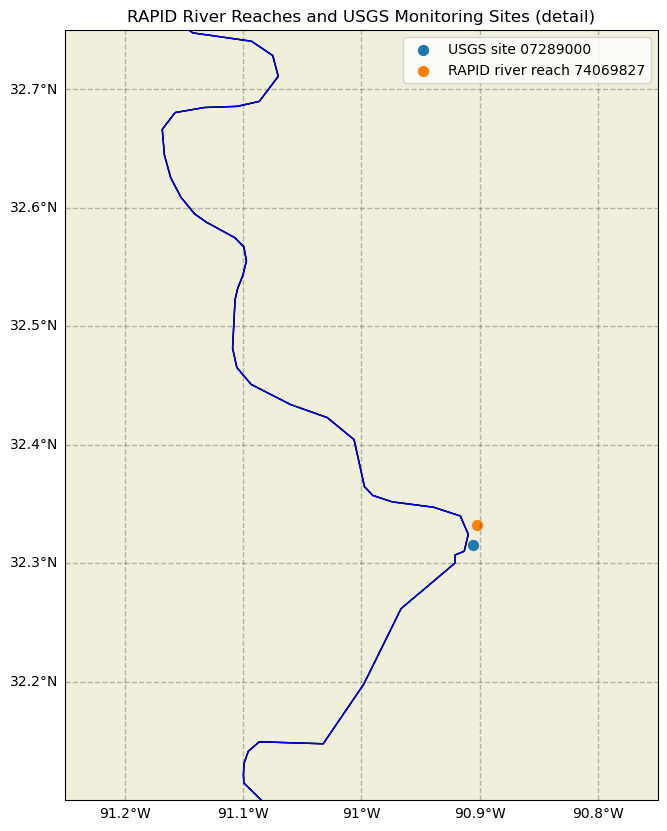

In [58]:
points = [
    (32.315, -90.905833, 'USGS site 07289000'),
    (32.3325, -90.9025, 'RAPID river reach 74069827')
]
plotting.map_points(points, 'RAPID River Reaches and USGS Monitoring Sites')
plotting.map_points(points, 'RAPID River Reaches and USGS Monitoring Sites (detail)', True)

In [61]:
usgs_params = (BASE_URL, 'USGS', 'IDEAS', '-91,32,-90,33', datetime(2018, 11, 1), datetime(2019,9,1), 'Streamflow')

In [82]:
miss_usgs_df = ideas_processing.insitu(*usgs_params)

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=USGS&project=IDEAS&startTime=2018-11-01T00:00:00Z&endTime=2019-09-01T00:00:00Z&bbox=-91,32,-90,33&variable=Streamflow
http://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=USGS&project=IDEAS&startTime=2018-11-01T00:00:00Z&endTime=2019-09-01T00:00:00Z&bbox=-91,32,-90,33&variable=Streamflow&markerTime=2018-12-01T09:00:00Z&markerPlatform=dd6a573de6911b0d69e4cccbc8e988c3218ee5f59cd78efae2e663ec4c977733
http://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=USGS&project=IDEAS&startTime=2018-11-01T00:00:00Z&endTime=2019-09-01T00:00:00Z&bbox=-91,32,-90,33&variable=Streamflow&markerTime=2018-12-30T13:45:00Z&markerPlatform=d55e7760dafaab6db4010c25583a40634c21223cb15095ba410ade224de5ce7e
http://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/

In [83]:
miss_usgs_site_df = miss_usgs_df[miss_usgs_df['site'] == '07289000']
try:
    miss_usgs_site_df['time'] = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ') for t in miss_usgs_site_df['time']]
except:
    pass

In [84]:
rapid_lis_miss_params = (BASE_URL, 'RAPID_LIS_Mississippi', 'IDEAS', '-91,32,-90,33', datetime(2018, 11, 1), datetime(2019,9,1), 'Qout')

In [101]:
rapid_lis_miss_df = ideas_processing.insitu(*rapid_lis_miss_params)

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=RAPID_LIS_Mississippi&project=IDEAS&startTime=2018-11-01T00:00:00Z&endTime=2019-09-01T00:00:00Z&bbox=-91,32,-90,33&variable=Qout
http://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=RAPID_LIS_Mississippi&project=IDEAS&startTime=2018-11-01T00:00:00Z&endTime=2019-09-01T00:00:00Z&bbox=-91,32,-90,33&variable=Qout&markerTime=2019-08-30T00:00:00.000000000&markerPlatform=81d1b69cd26c5294930ebc520a5efe9d09889b24b8686f14200b0037b1463f3e


In [111]:
rapid_lis_miss_site_df = rapid_lis_miss_df[rapid_lis_miss_df['site'] == '74069827']
try:
    rapid_lis_miss_site_df['time'] = [datetime.strptime(t.split('.')[0], '%Y-%m-%dT%H:%M:%S') for t in rapid_lis_miss_site_df['time']]
except:
    pass

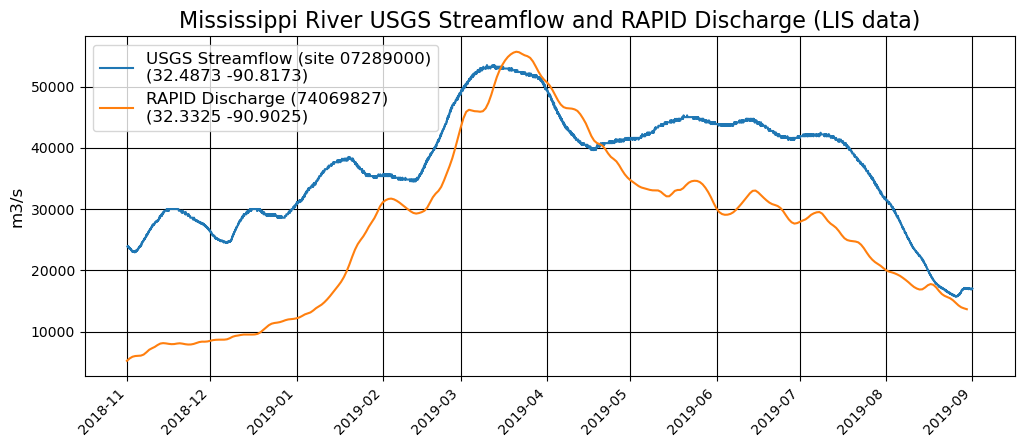

In [128]:
plotting.plot_insitu([(miss_usgs_site_df, 'Streamflow', 'USGS Streamflow (site 07289000)\n(32.4873 -90.8173)'), (rapid_lis_miss_site_df, 'Qout', 'RAPID Discharge (74069827)\n(32.3325 -90.9025)')], 'Mississippi River USGS Streamflow and RAPID Discharge (LIS data)')

# Flooding in Garonne

In [38]:
gar_bb = {'min_lon': -0.5, 'max_lon': 0.5, 'min_lat': 44.25, 'max_lat': 44.75}
gar_start    = datetime(2021, 1, 1)
gar_end     = datetime(2021, 3, 1)
gar_lis_params = [(BASE_URL, ds, gar_bb, gar_start, gar_end) for ds in ['LIS_gar_1x_Qs_tavg', 'LIS_gar_1x_Qsb_tavg']]

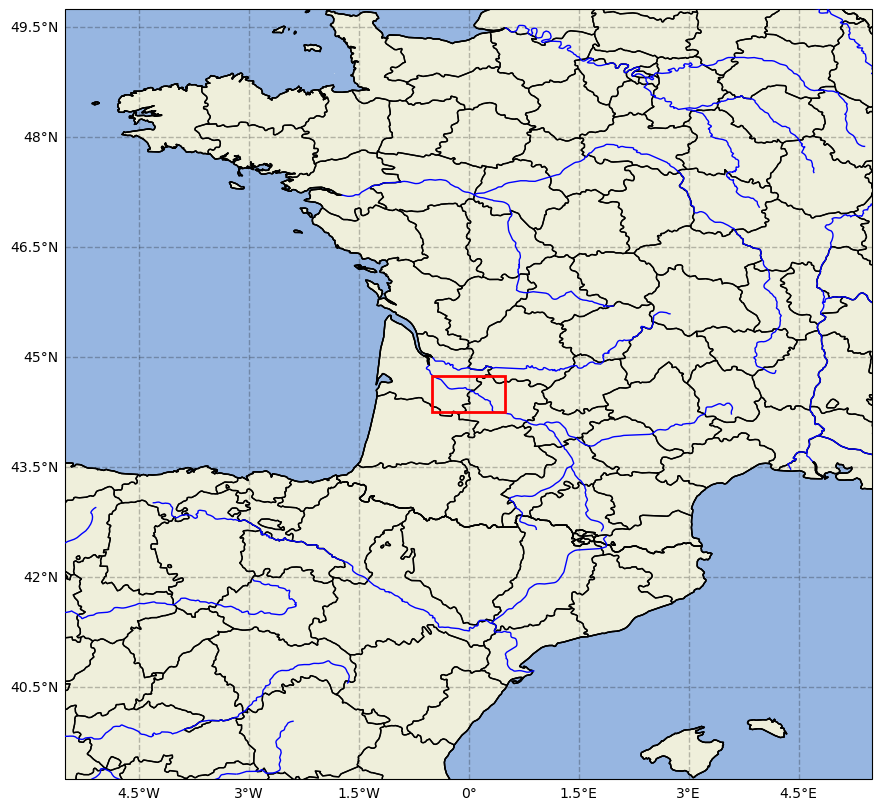

In [39]:
plotting.map_box(gar_bb, 5)

In [42]:
gpm_gar_ts = ideas_processing.spatial_timeseries(BASE_URL, 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed', gar_bb, gar_start, gar_end)

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed&minLon=-0.5&minLat=44.25&maxLon=0.5&maxLat=44.75&startTime=2021-01-01T00:00:00Z&endTime=2021-03-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.30818325001746416 seconds


## LIS Runoff and GPM Precipitation

In [43]:
gar_lis_ts = [ideas_processing.spatial_timeseries(*param) for param in gar_lis_params]

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=LIS_gar_1x_Qs_tavg&minLon=-0.5&minLat=44.25&maxLon=0.5&maxLat=44.75&startTime=2021-01-01T00:00:00Z&endTime=2021-03-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.30274212500080466 seconds
url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=LIS_gar_1x_Qsb_tavg&minLon=-0.5&minLat=44.25&maxLon=0.5&maxLat=44.75&startTime=2021-01-01T00:00:00Z&endTime=2021-03-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.2347079999744892 seconds


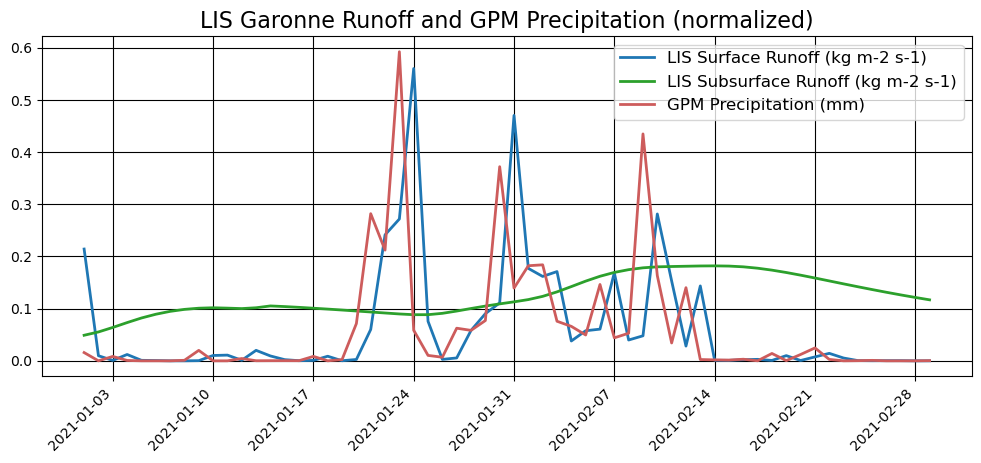

In [44]:
plotting.timeseries_plot([(gar_lis_ts[0]['mean'], 'LIS Surface Runoff (kg m-2 s-1)', 'tab:blue'), (gar_lis_ts[1]['mean'], 'LIS Subsurface Runoff (kg m-2 s-1)', 'tab:green'), (gpm_gar_ts['mean'], 'GPM Precipitation (mm)', 'indianred')], '', '', 'LIS Garonne Runoff and GPM Precipitation (normalized)', norm=True)

## VIC Runoff and GPM Precipitation

In [45]:
gar_vic_params = [(BASE_URL, ds, gar_bb, gar_start, gar_end) for ds in ['GLDAS_VIC10_3H_2_1_global_Qs_acc', 'GLDAS_VIC10_3H_2_1_global_Qsb_acc']]

In [47]:
gar_vic_ts = [ideas_processing.spatial_timeseries(*param) for param in gar_vic_params]

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GLDAS_VIC10_3H_2_1_global_Qs_acc&minLon=-0.5&minLat=44.25&maxLon=0.5&maxLat=44.75&startTime=2021-01-01T00:00:00Z&endTime=2021-03-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.1385459580924362 seconds
url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GLDAS_VIC10_3H_2_1_global_Qsb_acc&minLon=-0.5&minLat=44.25&maxLon=0.5&maxLat=44.75&startTime=2021-01-01T00:00:00Z&endTime=2021-03-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.9483554170001298 seconds


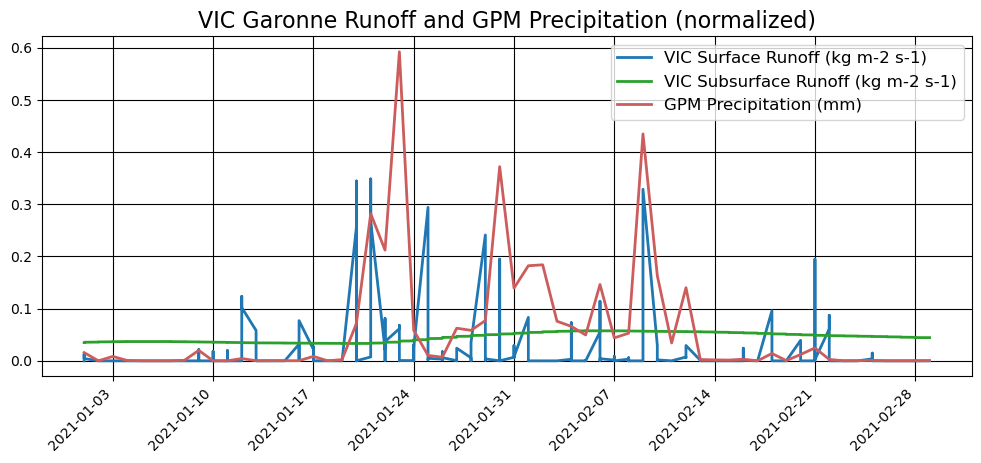

In [48]:
plotting.timeseries_plot([(gar_vic_ts[0]['mean'], 'VIC Surface Runoff (kg m-2 s-1)', 'tab:blue'), (gar_vic_ts[1]['mean'], 'VIC Subsurface Runoff (kg m-2 s-1)', 'tab:green'), (gpm_gar_ts['mean'], 'GPM Precipitation (mm)', 'indianred')], '', '', 'VIC Garonne Runoff and GPM Precipitation (normalized)', norm=True)

# LIS Soil Evaporation

Visualize LIS data.

- data set: LIS-ESoil-tavg
- spatial box:  -108, 32, -84, 42
- temporal box: 2019-12-1 to 2020-1-31

In [ ]:
global_precipitation_dataset  = 'GPM-3IMERGHHR-06-daily-global-precipitationCal_transposed'
soil_dataset = 'LIS-ESoil-tavg'
soil_bb      = {'min_lon': -94.5, 'max_lon': -88, 'min_lat': 29, 'max_lat': 38}
soil_start   = datetime(2020, 1, 1)
soil_end     = datetime(2020, 1, 31)
lis_evap_parameters = (BASE_URL, soil_dataset, soil_bb, soil_start, soil_end)
lis_rain_parameters = (BASE_URL, global_precipitation_dataset, soil_bb, soil_start, soil_end)

In [ ]:
plotting.map_box(soil_bb)

#### Precipitation and Direct Evaporation from Bare Soil 2020-1-1 to 2020-01-31

In [ ]:
lis_evap_timeseries = ideas_processing.spatial_timeseries(*lis_evap_parameters)
lis_rain_timeseries = ideas_processing.spatial_timeseries(*lis_rain_parameters)

#### Precipitation Time Series 2020-1-1 to 2020-01-31

In [ ]:
lis_title = f'Mississippi Precipitation Time Series ($mm$)\n{str(soil_start)[:10]} - {str(soil_end)[:10]}'
plotting.timeseries_plot([(lis_rain_timeseries['maximum'], 'precipitation')], '', '', title=lis_title, norm=False)

#### Normalized Precipitation and Direct Evaporation from Bare Soil 2020-1-1 to 2020-01-31

In [ ]:
lis_title = f'Direct Evaporation from Bare Soil and Precipitation Time Series\n{str(soil_start)[:10]} - {str(soil_end)[:10]}'
plotting.timeseries_plot([(lis_rain_timeseries['maximum'], 'precipitation'), (lis_evap_timeseries['maximum'], 'evaporation')], '', 'Normalized values', title=lis_title, norm=True)

#### Temporal Average of Precipitation and Direct Evaporation from Bare Soil 2020-1-1 to 2020-01-31

In [ ]:
miss_rain_timeavg = ideas_processing.temporal_mean(*lis_rain_parameters)

In [ ]:
plotting.map_data(miss_rain_timeavg, f'Mississippi Average Precipitation ($mm$)\n{str(soil_start)[:10]} - {str(soil_end)[:10]}')

In [ ]:
lis_timeavg = ideas_processing.temporal_mean(*lis_evap_parameters)

In [ ]:
soil_title = f'Average Direct Evaporation from Bare Soil ($kg/m^2/s$)\n{str(soil_start)[:10]} - {str(soil_end)[:10]}'
plotting.map_data(lis_timeavg, soil_title)

#### Latitude Time Hovmöller Analysis

In [ ]:
mis_evap_lat_hof = ideas_processing.hofmoeller(*lis_evap_parameters, dim='latitude')
mis_rain_lat_hof = ideas_processing.hofmoeller(*lis_rain_parameters, dim='latitude')

In [ ]:
mis_rain_hof_title = 'Mississippi Precipitation Latitude Time Hovmöller ($kg/m^2/s$)'
plotting.heatmap(mis_rain_lat_hof['mean'].transpose(), '', 'Latitude', mis_rain_hof_title)

In [ ]:
mis_evap_hof_title = 'Mississippi Average Direct Evaporation from Bare Soil Latitude Time HofMoeller ($kg/m^2/s$)'
plotting.heatmap(mis_evap_lat_hof['mean'].transpose(), '', 'Latitude', mis_evap_hof_title)

#### IDEAS WMS Visual 2020-01-20

In [ ]:
# Connect to IDEAS WMS Service
wms = WebMapService('https://ideas-digitaltwin.jpl.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

# Get IMERG_Precipitation_Rate
img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'LIS_HIST_ESoil_tavg',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-94.5,29,-88,38),  # Bounds
                 size=(400, 550),  # Image size
                 time='2020-01-20',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('LIS_HIST_ESoil_tavg_2020-01-20.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('LIS_HIST_ESoil_tavg_2020-01-20.png')

#### IDEAS WMS Animation 2020-01-01 to 2020-01-31

In [ ]:
wms = WebMapService('https://ideas-digitaltwin.jpl.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'LIS_HIST_ESoil_tavg',
          'Reference_Features',
          'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2020, 1, 1)
edate = datetime(2020, 2, 1)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(-94.5,29,-88,38),  # Bounds
                     size=(400, 550),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'LIS ESoil Avg   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('LIS_HIST_ESoil_tavg.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

In [ ]:
Image('LIS_HIST_ESoil_tavg.gif')